# Topic 1D - SVM + PCA (Wine Quality)

### Script mapping (what this notebook corresponds to)
- `svm_pca_ex4.py` — SVM classification with reports, and PCA as a dimensionality-reduction step (Lecture 1)

Dataset:
- `winequality-white.csv` (semicolon-separated)

---

## Learning goals
By the end you should be able to explain:

1. What an **SVM** is: margin, support vectors, and the role of **kernels**.
2. Why **scaling** matters a lot for SVM (especially with RBF kernel).
3. How to evaluate classification with **accuracy, precision, recall, F1**, and a **confusion matrix**.
4. Why PCA must be inside a **Pipeline** (to avoid leakage).
5. How PCA can help SVM (speed/regularization) and when it can hurt (drops predictive directions).


In [33]:
# Setup
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

def find_file(filename: str) -> Path:
    """Try common locations so the notebook runs in your repo and in this sandbox."""
    candidates = [
        Path(filename),
        Path('..') / 'datasets' / 'raw' / 'Topic1' / filename,
        Path('..') / 'datasets' / filename,
        Path('/mnt/data') / filename,  # sandbox
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find {filename}. Tried: {candidates}")

print('Ready ✅')

Ready ✅


## 1) Load the dataset

📌 Dataset info:
- 4,898 samples
- 11 numeric features (chemistry measurements)
- target: `quality` (integer score, typically 3–9)

In this notebook we start with a **binary** target to make evaluation clear:
- **good = 1** if quality ≥ 7
- **not good = 0** otherwise

(We can also switch to multiclass later if you want.)


In [34]:
path = find_file('winequality-white.csv')
df = pd.read_csv(path, sep=';')

print('Shape:', df.shape)
display(df.head())

Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Missing values per column: 0


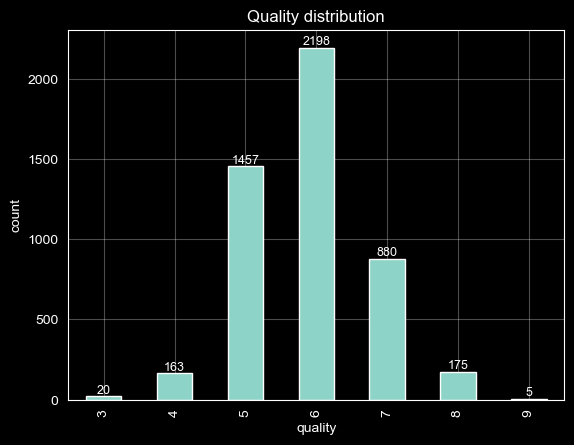

In [35]:
print('Missing values per column:', df.isna().sum().sum())

ax = df["quality"].value_counts().sort_index().plot(kind="bar")

for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=9, rotation=0)

plt.xlabel("quality")
plt.ylabel("count")
plt.title("Quality distribution")
plt.grid(True, alpha=0.3)
plt.show()

## 2) Define X and y (binary target)

We create:
- **X** = the 11 feature columns
- **y** = 0/1 target based on quality threshold

Why binarize?
- Confusion matrix + precision/recall are easier to interpret.
- In business settings, “good vs not good” is a common framing.

Threshold used here: **quality ≥ 7**.


In [36]:
X = df.drop(columns=['quality'])
y = (df['quality'] >= 7).astype(int)   # 1 = good, 0 = not good

print('X shape:', X.shape)
print('Class counts (0=not good, 1=good):', np.bincount(y))

X shape: (4898, 11)
Class counts (0=not good, 1=good): [3838 1060]


## 3) SVM intuition (quick but important)

📌 Documentation:
- [SVC (scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

### What an SVM tries to do (linear case)
SVM searches for a separating hyperplane that **maximizes the margin** between classes.

A linear decision rule looks like:

$$
\hat{y} = \mathrm{sign}(w^T x + b)
$$

- The points closest to the boundary are the **support vectors**.
- They “support” the optimal margin; many other points don’t directly affect the boundary.

### Nonlinear SVM (kernel trick)
When the data is not linearly separable, SVM uses a **kernel** (e.g., RBF) to model nonlinear boundaries.

Two key hyperparameters:
- **C**: penalty for misclassification (higher C → less regularization, tighter fit)
- **gamma** (RBF): how “local” the influence of a point is (higher gamma → more complex boundary)

## 4) Train/test split (stratified)

We keep class proportions the same in train and test using `stratify=y`.


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)

print('Train class counts:', np.bincount(y_train))
print('Test  class counts:', np.bincount(y_test))

Train class counts: [2686  742]
Test  class counts: [1152  318]


## 5) Baseline SVM (with scaling) — no PCA

### Why scaling is crucial for SVM
SVM (especially with RBF kernel) uses distances between points.  
If one feature has larger units, it dominates the distance, which can ruin the boundary.

So we use a Pipeline:

1) `StandardScaler()`  
2) `SVC(...)`

This also prevents leakage when we do cross-validation.


In [38]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

pipe_svm.fit(X_train, y_train)

test_acc = pipe_svm.score(X_test, y_test)
print('Test accuracy (scaled SVM, no PCA):', round(test_acc, 4))

Test accuracy (scaled SVM, no PCA): 0.8286


In [39]:
# Detailed classification metrics on the test set
y_pred = pipe_svm.predict(X_test)

print('Confusion matrix (test):')
cm = confusion_matrix(y_test, y_pred)
display(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

print('\nClassification report (test):')
print(classification_report(y_test, y_pred, digits=4))

Confusion matrix (test):


,Pred 0,Pred 1
Actual 0,1116,36
Actual 1,216,102



Classification report (test):
              precision    recall  f1-score   support

           0     0.8378    0.9688    0.8986      1152
           1     0.7391    0.3208    0.4474       318

    accuracy                         0.8286      1470
   macro avg     0.7885    0.6448    0.6730      1470
weighted avg     0.8165    0.8286    0.8009      1470



## 6) Cross-validation baseline (more stable estimate)

Accuracy can be misleading with class imbalance, so we evaluate both:
- **accuracy**
- **f1** (binary F1 focuses on precision/recall balance for the positive class)

We use **StratifiedKFold** to keep class proportions similar in each fold.


In [40]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_scores = cross_val_score(pipe_svm, X, y, cv=cv, scoring='accuracy')
f1_scores  = cross_val_score(pipe_svm, X, y, cv=cv, scoring='f1')

print('CV Accuracy:', round(acc_scores.mean(), 4), '±', round(acc_scores.std(), 4))
print('CV F1      :', round(f1_scores.mean(), 4),  '±', round(f1_scores.std(), 4))

CV Accuracy: 0.822 ± 0.0133
CV F1      : 0.442 ± 0.0439


## 7) PCA step: explained variance (how many components?)

We inspect PCA on the **scaled** features to see how many components capture 90–95% of variance.

Even if PCA keeps most variance, remember:
- PCA is unsupervised → high variance ≠ high predictiveness


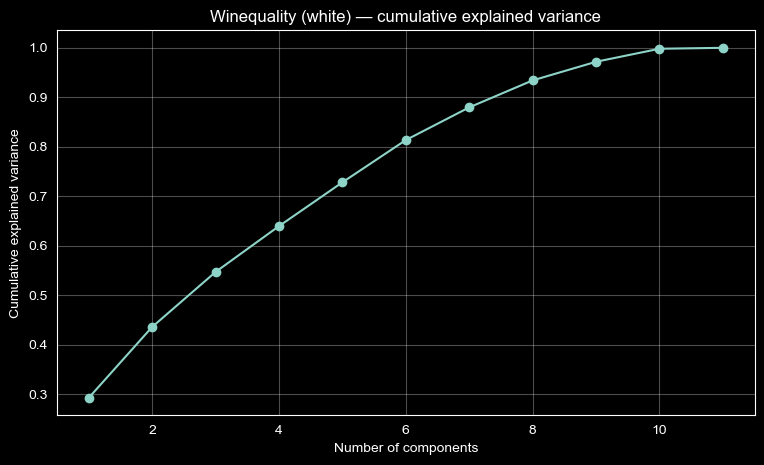

Components for ≥90% variance: 8
Components for ≥95% variance: 9


In [41]:
# Fit scaler + PCA for inspection (not evaluation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_all = PCA().fit(X_scaled)
cum = np.cumsum(pca_all.explained_variance_ratio_)

plt.figure(figsize=(9, 5))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.title('Winequality (white) — cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True, alpha=0.3)
plt.show()

k90 = np.argmax(cum >= 0.90) + 1
k95 = np.argmax(cum >= 0.95) + 1
print('Components for ≥90% variance:', k90)
print('Components for ≥95% variance:', k95)

## 8) SVM + PCA (inside a Pipeline)

We compare baseline vs PCA version **fairly** using pipelines + the same CV folds.

Pipeline order:
1) StandardScaler
2) PCA(k)
3) SVC


In [42]:
k = 6  # start with a lecture-like choice; you will tune this next

pipe_svm_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=k)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

acc_scores_pca = cross_val_score(pipe_svm_pca, X, y, cv=cv, scoring='accuracy')
f1_scores_pca  = cross_val_score(pipe_svm_pca, X, y, cv=cv, scoring='f1')

print(f'CV Accuracy (SVM + PCA({k})): {acc_scores_pca.mean():.4f} ± {acc_scores_pca.std():.4f}')
print(f'CV F1       (SVM + PCA({k})): {f1_scores_pca.mean():.4f} ± {f1_scores_pca.std():.4f}')

print('\nDelta vs baseline:')
print('  ΔAccuracy:', round(acc_scores_pca.mean() - acc_scores.mean(), 4))
print('  ΔF1      :', round(f1_scores_pca.mean()  - f1_scores.mean(), 4))

CV Accuracy (SVM + PCA(6)): 0.8109 ± 0.0094
CV F1       (SVM + PCA(6)): 0.3305 ± 0.0347

Delta vs baseline:
  ΔAccuracy: -0.011
  ΔF1      : -0.1114


## 9) Sweep k: performance vs number of components

We sweep several k values and track both accuracy and F1.

What to look for:
- small k: underfitting (too much information removed)
- medium k: possible speed/regularization benefit
- large k: approaches baseline (similar to original feature space)


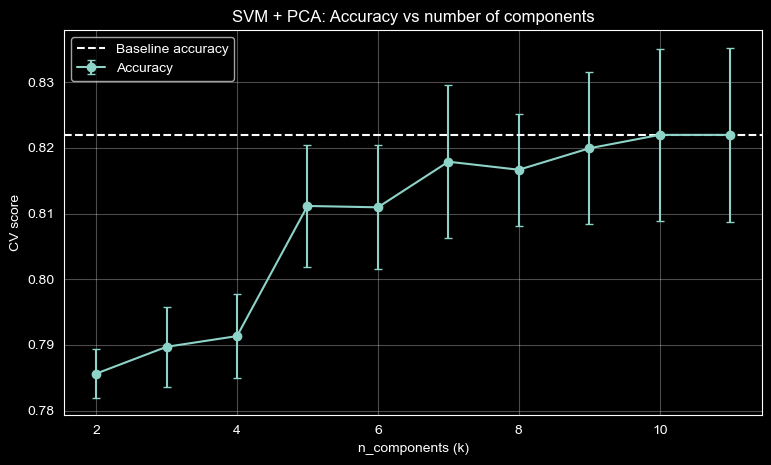

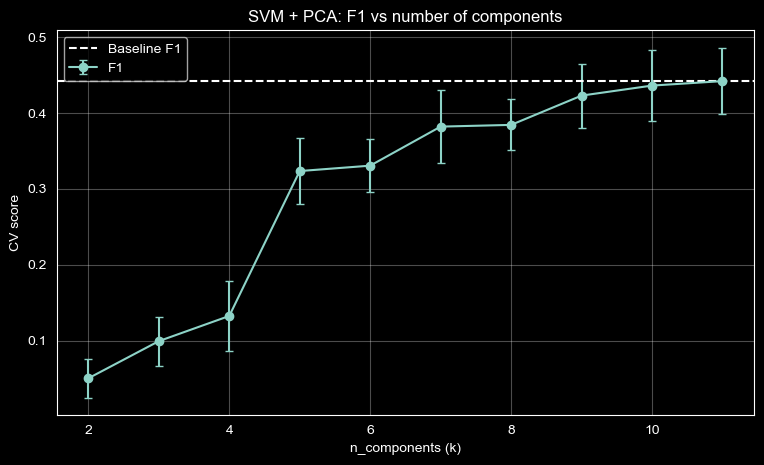

Best k by accuracy: 10 | best mean acc: 0.822
Best k by F1      : 11 | best mean F1 : 0.442


In [43]:
ks = list(range(2, X.shape[1] + 1))  # 2..11
acc_means, f1_means = [], []
acc_stds, f1_stds = [], []

for k in ks:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=k)),
        ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    a = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    f = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    acc_means.append(a.mean()); acc_stds.append(a.std())
    f1_means.append(f.mean());  f1_stds.append(f.std())

plt.figure(figsize=(9, 5))
plt.errorbar(ks, acc_means, yerr=acc_stds, marker='o', capsize=3, label='Accuracy')
plt.axhline(acc_scores.mean(), linestyle='--', label='Baseline accuracy')
plt.xlabel('n_components (k)')
plt.ylabel('CV score')
plt.title('SVM + PCA: Accuracy vs number of components')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(9, 5))
plt.errorbar(ks, f1_means, yerr=f1_stds, marker='o', capsize=3, label='F1')
plt.axhline(f1_scores.mean(), linestyle='--', label='Baseline F1')
plt.xlabel('n_components (k)')
plt.ylabel('CV score')
plt.title('SVM + PCA: F1 vs number of components')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

best_k_acc = ks[int(np.argmax(acc_means))]
best_k_f1  = ks[int(np.argmax(f1_means))]

print('Best k by accuracy:', best_k_acc, '| best mean acc:', round(max(acc_means), 4))
print('Best k by F1      :', best_k_f1,  '| best mean F1 :', round(max(f1_means), 4))

### ✅ Interpretation of results (SVM baseline vs SVM + PCA)

#### 1) Data + class balance (important for metric choice)
- Total samples: **4898**
- Features: **11**
- Binary target (quality ≥ 7):
  - Class 0 (not good): **3838**
  - Class 1 (good): **1060**

✅ This is **imbalanced** (the positive “good” class is much smaller), so **F1** is more informative than accuracy.

---

#### 2) Baseline SVM (scaled, no PCA) - test-set view
**Test accuracy:** 0.8286

Confusion matrix (test):
- TN = 1116, FP = 36
- FN = 216,  TP = 102

For class 1 (“good”), the report shows:
- Precision = 0.7391
- Recall    = 0.3208
- F1        = 0.4474

✅ Interpretation:
- The model is very good at identifying class 0 (high recall for class 0).
- But for class 1 it has **low recall**: it misses many good wines (**many false negatives**).
- This is a typical pattern with imbalanced data: accuracy looks decent mainly because class 0 is common.

---

#### 3) Cross-validation baseline (more reliable estimate)
- **CV Accuracy:** 0.8220 ± 0.0133
- **CV F1:** 0.4420 ± 0.0439

✅ Interpretation:
- Average performance is stable in accuracy (small std).
- F1 has higher variance (std ≈ 0.044), which is normal because the minority class is harder.

---

#### 4) PCA variance context (how many PCs represent most variance?)
From PCA on scaled features:
- **k90 = 8** components for ≥90% variance
- **k95 = 9** components for ≥95% variance

So PCA compression is possible, but it doesn’t guarantee better classification (PCA is unsupervised).

---

#### 5) SVM + PCA(k=6) - what happened?
- **CV Accuracy:** 0.8109 ± 0.0094
- **CV F1:** 0.3305 ± 0.0347

Delta vs baseline:
- **ΔAccuracy = −0.0110**
- **ΔF1 = −0.1114**

✅ Interpretation:
- PCA with k=6 is **too aggressive** here.
- It likely removed lower-variance directions that are still useful for predicting “good” wines.
- The F1 drop is large compared to its CV std, so this is a **real degradation**, not just noise.

---

#### 6) Sweep conclusion (best k)
- Best k by accuracy: **10**, best mean acc ≈ **0.822** (≈ baseline)
- Best k by F1: **11**, best mean F1 ≈ **0.442** (≈ baseline)

✅ Interpretation:
- PCA helps only when k is large (10–11), meaning we’re barely reducing dimensionality.
- In other words: **PCA does not improve this task**, and strong dimensionality reduction hurts.
- The best-performing PCA setting is effectively “almost no reduction”.

---

#### 7) Final takeaway (business + exam-ready)
- With imbalanced targets, **F1 is the metric to trust**, not accuracy.
- Baseline scaled SVM performs best overall.
- PCA with small k harms recall/F1 for the minority “good” class.
- If you use PCA here, it should be for **computational reasons** (speed) and with **k near 10–11**, not for better predictive performance.

**One sentence:**
PCA is unsupervised, so preserving variance (especially with small k) does not guarantee preserving the features that separate “good” vs “not good” wines.
